### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, History, ReduceLROnPlateau, EarlyStopping

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = './D39_kaggle人臉關鍵點資料集/training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPool2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [5]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mse', optimizer='adam')

In [6]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [7]:
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True)
ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=0.00001)
EarlyStop = EarlyStopping(monitor="loss", patience=5, verbose=1)
hist = History()

In [8]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64,
                       callbacks=[checkpoint, ReduceLR, EarlyStop, hist],
                       shuffle=True, epochs=100, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/100
27/27 [==============================] - 27s 76ms/step - loss: 0.0138 - val_loss: 0.0025
Epoch 2/100
27/27 [==============================] - 1s 25ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/100
27/27 [==============================] - 1s 27ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/100
27/27 [==============================] - 1s 26ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 7/100
27/27 [==============================] - 1s 26ms/step - loss: 9.5090e-04 - val_loss: 0.0017
Epoch 8/100
27/27 [==============================] - 1s 27ms/step - loss: 8.3157e-04 - val_loss: 0.0016
Epoch 9/100
27/27 [==============================] - 1s 27ms/step - loss: 7.3589e-04 - val_loss: 0.0015
Epoch 10/100
27/27 [==============================] - 1s 26ms/step - loss: 7.0170e-04 -

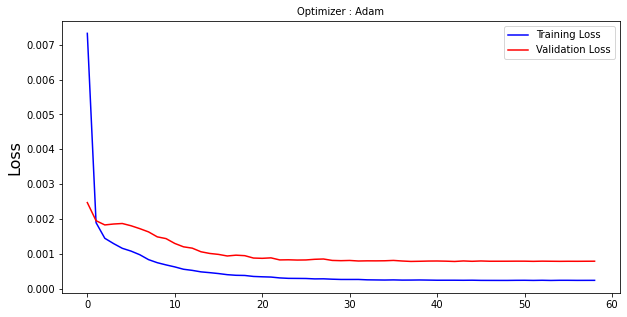

In [9]:
# loss 值的圖

plt.figure(figsize = (10, 5))
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

### 觀察 model 在 testing 上的結果

In [10]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = './D39_kaggle人臉關鍵點資料集/test.csv')

In [11]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for corrd in points.reshape(15,2):
        plt.plot(*(corrd + 0.5) * 96, 'ro')

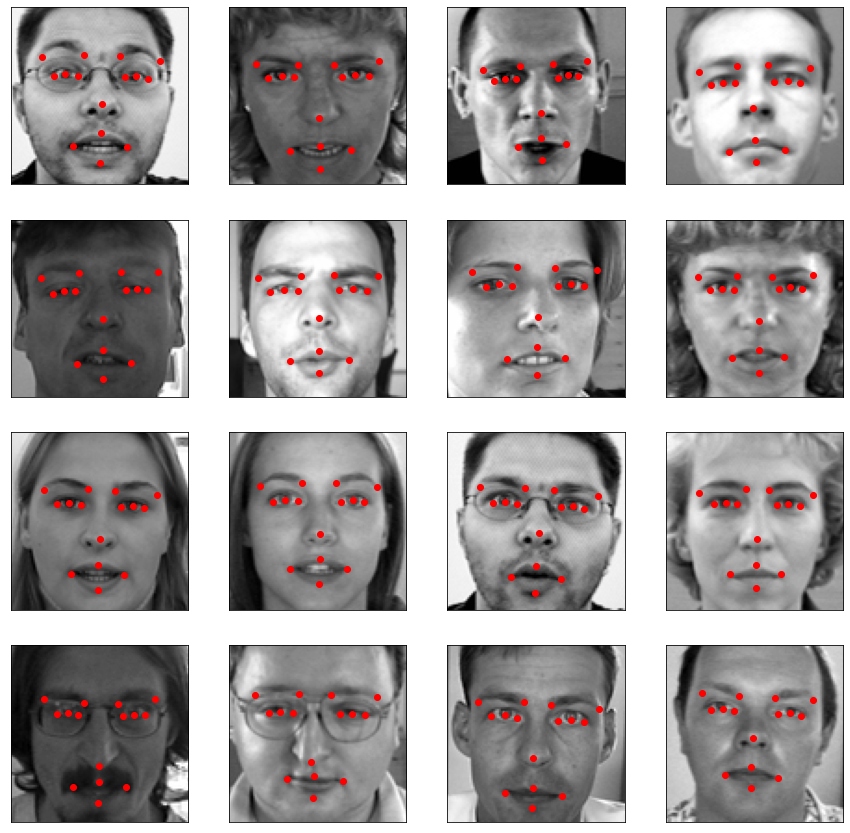

In [12]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [13]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




In [14]:
# 取得左右對稱col的idx
data = pd.read_csv('./D39_kaggle人臉關鍵點資料集/training.csv',
                   skiprows=lambda x: x > 0)
left, right =[], []
for i, tag in enumerate(data.columns):
    if 'left' in tag:
        left.append(i)
    elif 'right' in tag:
        right.append(i)
print(list(zip(left,right)))

[(0, 2), (1, 3), (4, 8), (5, 9), (6, 10), (7, 11), (12, 16), (13, 17), (14, 18), (15, 19), (22, 24), (23, 25)]


In [15]:
def augment_data(img, points):
    rows, cols = img.shape
    
    # 翻轉圖片
    new_img = np.copy(img)[...,::-1]
            
    # 翻轉關鍵點的y值 
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]

    # 調整對稱的 label    
    flip_indexs=[(0, 2), (1, 3), (4, 8), (5, 9), (6, 10), (7, 11), (12, 16),
                 (13, 17), (14, 18), (15, 19), (22, 24), (23, 25)]
    for l, r in flip_indexs:
        new_points[l], new_points[r] = new_points[r], new_points[l]
        
    return new_img, new_points

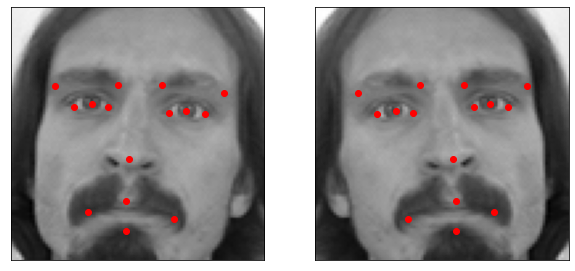

In [16]:
# 輸出對稱圖比較
fig = plt.figure(figsize = (10, 5))

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) 

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(*augment_data(imgs_train[0], points_train[0]))

plt.show()

In [17]:
# 創建 list
aug_imgs_train, aug_points_train = imgs_train.tolist(), points_train.tolist()

# 擴展訓練集
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [18]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mse', optimizer='adam')

# 儲存history開始位置
sep = len(hist_model.history['loss'])

# training the model
hist_model = model.fit(aug_imgs_train.reshape(-1, 96, 96, 1), 
                       aug_points_train, 
                       validation_split=0.2, batch_size=64,
                       callbacks=[checkpoint, ReduceLR, EarlyStop, hist],
                       shuffle=True, epochs=100, verbose=1)
# save the model weights
model.save_weights('weights_aug.h5')
# save the model
model.save('model_aug.h5')

Epoch 1/100
54/54 [==============================] - 4s 39ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 2/100
54/54 [==============================] - 1s 24ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/100
54/54 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/100
54/54 [==============================] - 1s 24ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/100
54/54 [==============================] - 1s 24ms/step - loss: 7.8976e-04 - val_loss: 8.4866e-04
Epoch 6/100
54/54 [==============================] - 1s 24ms/step - loss: 6.2462e-04 - val_loss: 7.0844e-04
Epoch 7/100
54/54 [==============================] - 1s 25ms/step - loss: 5.2282e-04 - val_loss: 6.7040e-04
Epoch 8/100
54/54 [==============================] - 1s 25ms/step - loss: 4.8011e-04 - val_loss: 5.9453e-04
Epoch 9/100
54/54 [==============================] - 1s 26ms/step - loss: 4.1572e-04 - val_loss: 5.2678e-04
Epoch 10/100
54/54 [==============================] - 1s 26m

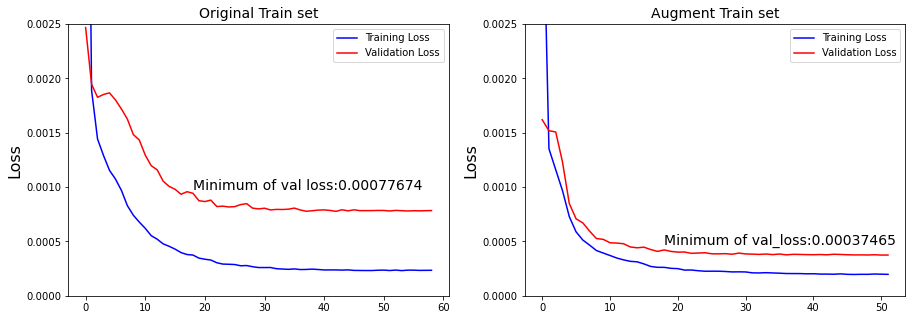

In [19]:
# 比較 loss值的圖
fig = plt.figure(figsize = (15, 5))

min_val_loss = round(min(hist_model.history["val_loss"][:sep]),8)
ax = fig.add_subplot(1, 2, 1, ylim=(0, 0.0025))
plt.title('Original Train set', fontsize=14)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'][:sep], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'][:sep], color='r', label='Validation Loss')
plt.text(18, min_val_loss+0.0002, f'Minimum of val loss:{min_val_loss} ', fontsize=14)
plt.legend(loc='upper right')

aug_min_val_loss = round(min(hist_model.history["val_loss"][sep:]),8)
ax = fig.add_subplot(1, 2, 2, ylim=(0, 0.0025))
plt.title('Augment Train set', fontsize=14)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'][sep:], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'][sep:], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.text(18, aug_min_val_loss+0.0001, f'Minimum of val_loss:{aug_min_val_loss} ', fontsize=14)
plt.show()